For the baseline model, the time series data for each patient is coerced into a single row to be pipelined into a simpler ML M1.


In [18]:
import numpy as np
from scipy.stats import loguniform, uniform
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

In row coercion, linearity is assumed and the grouped dataframe is collapsed by computing three features:
1. $\Delta t$ : the change in time from the second last reading from the first reading
2. $\Delta$ FVC : the change in FVC from the second last reading from the first reading
3. next_time : the change in time from the last reading which is being predicted to the second last reading

Then, the label will be the FVC reading from the last reading.


In [8]:
BASE_DIR = Path().resolve()
csv_path = BASE_DIR.parent / "data" / "train.csv"

df = pd.read_csv(csv_path)

rows = []
for pid, g in df.groupby("Patient", sort=False):
    g = g.reset_index(drop=True)
    baseline = g.iloc[0]
    pre_last = g.iloc[-2]
    last = g.iloc[-1]

    feature_row = {
        "Patient": pid,
        "Age": baseline["Age"],               
        "Sex": baseline["Sex"],
        "SmokingStatus": baseline["SmokingStatus"],
        "dFVC": pre_last["FVC"] - baseline["FVC"],
        "dPercent": pre_last["Percent"] - baseline["Percent"],
        "dweeks": pre_last["Weeks"] - baseline["Weeks"],
        "weeks_next": last["Weeks"] - pre_last["Weeks"], 
    }                                       # Columns of features
    feature_row["y_FVC_last"] = last["FVC"] # The label to predict

    rows.append(feature_row)

collapsed = pd.DataFrame(rows)
collapsed = collapsed.reset_index(drop=True)

X = collapsed.drop(columns=["y_FVC_last", "Patient"])
y = collapsed["y_FVC_last"]

print(collapsed.head())


                     Patient  Age   Sex SmokingStatus  dFVC   dPercent  \
0  ID00007637202177411956430   79  Male     Ex-smoker  -251  -6.316054   
1  ID00009637202177434476278   69  Male     Ex-smoker  -270  -6.291360   
2  ID00010637202177584971671   60  Male     Ex-smoker -1049 -28.204990   
3  ID00011637202177653955184   72  Male     Ex-smoker    20   0.517063   
4  ID00012637202177665765362   65  Male  Never smoked  -187  -5.127783   

   dweeks  weeks_next  y_FVC_last  
0      45          16        2057  
1      37          15        3214  
2      37          17        2518  
3      37          15        3193  
4      38          16        2971  


Next, the data is split 8:2 into train and validation set.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=3244
)

X_train.head()

,Age,Sex,SmokingStatus,dFVC,dPercent,dweeks,weeks_next
173,73,Male,Ex-smoker,-68,-2.701414,29,12
106,64,Male,Ex-smoker,-209,-6.174663,37,17
97,77,Female,Never smoked,-756,-38.288174,41,15
168,65,Male,Ex-smoker,190,5.293659,38,15
161,67,Male,Never smoked,14,0.350175,41,17


For the exploratory, baseline model, the row-coerced data will be passed into XGBoost, a tree-based boosting method that effectively handles the categorical features which are predominant in the given data.

MAE: 560.998779296875
R²: 0.0025038719177246094


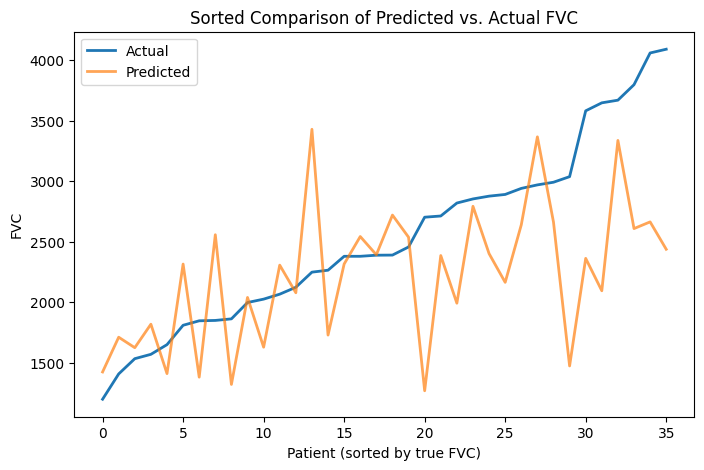

In [15]:
cat_cols = ["Sex", "SmokingStatus"]
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_val[c] = X_val[c].astype("category")

M1 = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",       # fast CPU training
    enable_categorical=True   # allows category dtype
)

M1.fit(X_train, y_train)

y_pred = M1.predict(X_val)
print("MAE:", mean_absolute_error(y_val, y_pred))
print("R²:", r2_score(y_val, y_pred))

order = np.argsort(y_val)
y_true_sorted = np.array(y_val)[order]
y_pred_sorted = np.array(y_pred)[order]

plt.figure(figsize=(8, 5))
plt.plot(y_true_sorted, label="Actual", lw=2)
plt.plot(y_pred_sorted, label="Predicted", lw=2, alpha=0.7)
plt.title("Sorted Comparison of Predicted vs. Actual FVC")
plt.xlabel("Patient (sorted by true FVC)")
plt.ylabel("FVC")
plt.legend()
plt.show()

This model has almost no predictive power over the dataset: Nonetheless, hyperparameter tuning is attempted to verify whether the model's performance can be enhanced.

In [21]:
Moptim = XGBRegressor(
    tree_method="hist",
    enable_categorical=True,
    n_estimators=1000,        
    objective="reg:squarederror",
    n_jobs=-1
)

param_dist = {
    "learning_rate": loguniform(1e-3, 2e-1),  # ~[0.001, 0.2]
    "max_depth":     [3,4,5,6,7,8],
    "min_child_weight": uniform(1, 5),        # [1,6)
    "subsample":     uniform(0.6, 0.4),       # [0.6,1.0)
    "colsample_bytree": uniform(0.6, 0.4),    # [0.6,1.0)
    "reg_lambda":    loguniform(1e-2, 1e2),   # [0.01,100]
    "reg_alpha":     loguniform(1e-3, 1e1),   # [0.001,10]
}

# --- CV setup ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

fit_params = {
    "eval_set": [(X_val, y_val)],    
    "verbose": False
}

search = RandomizedSearchCV(
    estimator=Moptim,
    param_distributions=param_dist,
    n_iter=60,                    
    scoring="neg_mean_absolute_error",
    cv=cv,
    random_state=3244,
    n_jobs=-1,
    refit=True
)

search.fit(X_train, y_train, **fit_params)

best = search.best_estimator_
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

# --- final eval on test set ---
y_pred = best.predict(X_val)
print("Test MAE:", mean_absolute_error(y_val, y_pred))

Best CV MAE: 542.5648315429687
Best params: {'colsample_bytree': np.float64(0.8906843740307104), 'learning_rate': np.float64(0.005652520143262533), 'max_depth': 3, 'min_child_weight': np.float64(4.581661879888676), 'reg_alpha': np.float64(0.005791400847430981), 'reg_lambda': np.float64(12.95318317933723), 'subsample': np.float64(0.8727952814245623)}
Test MAE: 555.6273803710938


Now, the obtained hyperparameters are used to build the optimized model.

MAE: 526.1000366210938
R²: 0.22093945741653442


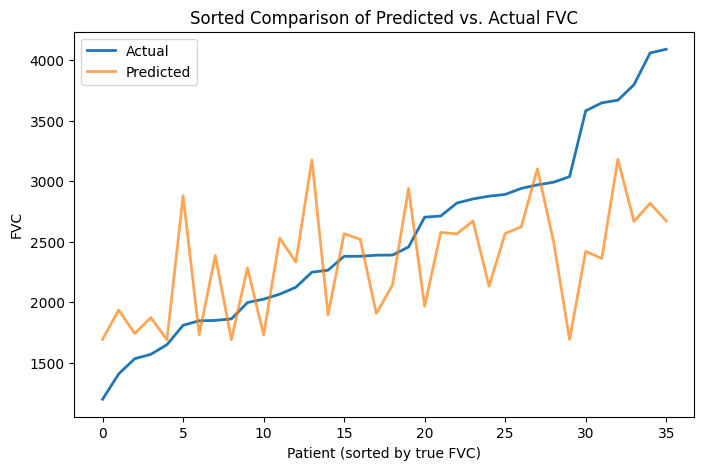

In [22]:
M2 = XGBRegressor(
    n_estimators=500,
    learning_rate=np.float64(0.005652520143262533),
    max_depth=3,
    colsample_bytree=np.float64(0.8906843740307104),
    min_child_weight=np.float64(4.581661879888676),
    reg_alpha=np.float64(0.005791400847430981),
    reg_lambda=np.float64(12.95318317933723),
    subsample=np.float64(0.8727952814245623),
    tree_method="hist",       # fast CPU training
    enable_categorical=True   # allows category dtype
)

M2.fit(X_train, y_train)

y_pred = M2.predict(X_val)
print("MAE:", mean_absolute_error(y_val, y_pred))
print("R²:", r2_score(y_val, y_pred))

order = np.argsort(y_val)
y_true_sorted = np.array(y_val)[order]
y_pred_sorted = np.array(y_pred)[order]

plt.figure(figsize=(8, 5))
plt.plot(y_true_sorted, label="Actual", lw=2)
plt.plot(y_pred_sorted, label="Predicted", lw=2, alpha=0.7)
plt.title("Sorted Comparison of Predicted vs. Actual FVC")
plt.xlabel("Patient (sorted by true FVC)")
plt.ylabel("FVC")
plt.legend()
plt.show()

Although the evaluation metric somewhat improved, this model is definitely not capturing the right patterns in the given data, thus justifying the use of a more complex, albeit less interpretable learning model.